In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [83]:
import scipy

In [72]:
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

<h5>Дані по кредитиних історіях клієнтів одного з банків:</h5>
<br>
<ul>
    <li>LIMIT_BAL: розмір кредитного ліміту (в том числі і на сім'ю клієнта)</li>
<li>SEX: стать клієнта (1 = чоловіча, 2 = жіноча )</li>
<li>EDUCATION: освіта (0 = доктор, 1 = магістр; 2 = бакалавр; 3 = випускник школи; 4 = початкова освіта; 5= інше; 6 = немає даних).</li>
<li>MARRIAGE: (0 = відмова відповісти; 1 = одружений(а); 2 = неодружений(а); 3 = немає даних).</li>
<li>AGE: вік в роках</li>
<li>PAY_0 - PAY_6 : Історія минулих платежей по кредиту. PAY_6 - платіж у квітні, ... Pay_0 - платіж у вересні. Платіж = (0 = вчасний платіж, 1=затримка в один місяць, 2=затримка в 2 місяці ...)</li>
<li>BILL_AMT1 - BILL_AMT6: зборгованістьь, BILL_AMT6 - на квітень, BILL_AMT1 - на вересень</li>
<li>PAY_AMT1 - PAY_AMT6: сумма виплачена в PAY_AMT6 - у квітні, ..., PAY_AMT1 - у вересні</li>
<li>default - індикатор неповернення грошових коштів</li>
</ul>

In [3]:
credit = pd.read_csv('credit_card_default_analysis.csv')

In [4]:
credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


##### Перевіримо нульову гіпотезу про рівність медіанних значень кредитного ліміту у групах людей,які повернули і не повернули кредит:
<ul>
    <li>H0: med1 = med2, де med1 - медіна вибірки LIMIT_BAL людей, які повернули кошти (default=0), а med2 - медіна вибірки LIMIT_BAL людей, які не повернули кошти (default=1)</li>
    <li>H1: med1 != med2</li>
</ul>
Для цьго використаємо інтервальну оцінку на основі бутстрепу, так як розподіл генеральної сукупності з якої взяли вибірку не відомий. Як видно з тесту Шапіро-Уілка нижче, це не нормальний розподіл, тому використати t-інтервал неможливо.

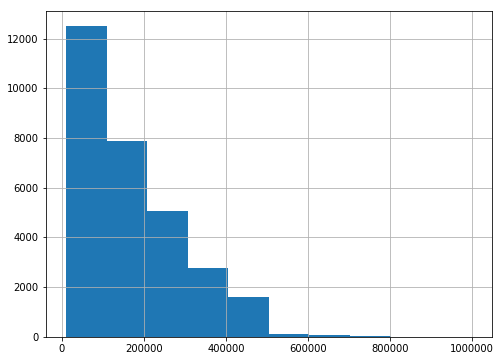

In [7]:
plt.figure(figsize=(8,6))
credit.LIMIT_BAL.hist();

Розподіл ознаки LIMIT_BAL скошений

In [8]:
credit[credit.LIMIT_BAL>800000]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
2197,2198,1000000,2,1,1,47,0,0,0,0,...,891586,927171,961664,50784,50723,896040,50000,50000,50256,0


Розподіл ознаки кредитний ліміт скошений і є викид у вигляді людини, у якої кредитний ліміт складає 1.000.000. Відкинемо цей викид

In [9]:
credit = credit[credit.LIMIT_BAL < 800000]

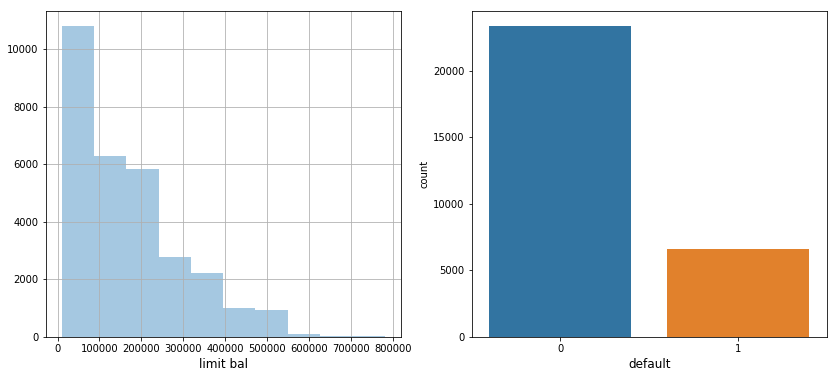

In [10]:
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.distplot(credit.LIMIT_BAL, bins=10, kde=False)
plt.grid(True)
plt.xlabel('limit bal', fontsize=12)
plt.subplot(122)
sns.countplot(credit.default)
plt.xlabel('default', fontsize=12)
plt.show()

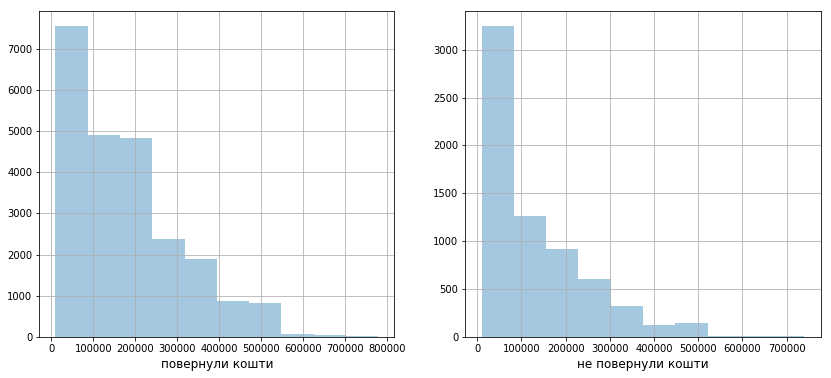

In [11]:
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.distplot(credit[credit.default == 0].LIMIT_BAL, bins=10, kde=False)
plt.grid(True)
plt.xlabel('повернули кошти', fontsize=12)
plt.subplot(122)
sns.distplot(credit[credit.default == 1].LIMIT_BAL, bins=10, kde=False)
plt.grid(True)
plt.xlabel('не повернули кошти', fontsize=12)
plt.show()

In [12]:
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(credit[credit.default == 0].LIMIT_BAL))
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(credit[credit.default == 1].LIMIT_BAL))

Shapiro-Wilk normality test, W-statistic: 0.920122, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.854983, p-value: 0.000000


C:\Users\Mariana\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Тест Шапіро-Уілка відхиляє нульову гіпотезу про нормальність вибірки людей, які повернули кредит на рівні значимості 0.05.
Тест Шапіро-Уілка відхиляє нульову гіпотезу про нормальність вибірки людей, які не повернули кредит на рівні значимості 0.05.

In [13]:
credit.default.value_counts()

0    23361
1     6636
Name: default, dtype: int64

Точкова оцінка медіан двох вибірок:

In [14]:
print ("LIMIT_BAL для людей, що повернули кредит: median %.3f, std %.3f" % (credit[credit.default == 0].LIMIT_BAL.median(),\
                                               credit[credit.default == 0].LIMIT_BAL.std()) )
print ("LIMIT_BAL для людей, що не повернули кредит: median %.3f, std %.3f" % (credit[credit.default == 1].LIMIT_BAL.median(), \
                                                 credit[credit.default == 1].LIMIT_BAL.std()) )

LIMIT_BAL для людей, що повернули кредит: median 150000.000, std 131400.957
LIMIT_BAL для людей, що не повернули кредит: median 90000.000, std 115378.541


In [15]:
return_median = credit[credit.default == 0].LIMIT_BAL.median()
not_return_median = credit[credit.default == 1].LIMIT_BAL.median()


###### Bootstrap

In [16]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [17]:
limit_return = credit[credit.default == 0].LIMIT_BAL.values
limit_not_return = credit[credit.default == 1].LIMIT_BAL.values

In [18]:
np.random.seed(0)

return_median_scores = list(map(np.median, get_bootstrap_samples(limit_return, 5000)))
not_return_median_scores = list(map(np.median, get_bootstrap_samples(limit_not_return, 5000)))

print ("95% confidence interval for the return median LIMIT_BAL:",  stat_intervals(return_median_scores, 0.05))
print ("95% confidence interval for the not_return median LIMIT_BAL:",  stat_intervals(not_return_median_scores, 0.05))

95% confidence interval for the return median LIMIT_BAL: [150000. 150000.]
95% confidence interval for the not_return median LIMIT_BAL: [80000. 90000.]


Точкова оцінка різниці медіан двох вибірок:

In [19]:
print ("difference between medians:", return_median - not_return_median)

difference between medians: 60000.0


Інтервальна оцінка різниці медіан:

In [105]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(return_median_scores, not_return_median_scores)))

In [106]:
print ("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-70000. -60000.]


За допомогою такого інтервалу можна перевірити H0: med2-med1=0, проти H1: med2-med1!=0.
<br>
H0 відхиляється на рівні значимості alpha, якщо довірчий інтервал для (med1-med2) із рівнем довіри 1-alpha не містить 0.


95% довірчий інтервал містить нуль, тому H0 не відхиляється на рівні значимості alpha = 0.05
<br>
Висновок: нульова гіпотеза про рівність медіанних значень кредитного ліміту у групах людей,які повернули і не повернули кредит не відхиляється

##### Перевіримо рівність розподілів непарметричними критеріями:

##### Ранговий критерій Манна-Уітні

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [48]:
stats.mannwhitneyu(limit_return, limit_not_return)

MannwhitneyuResult(statistic=59257217.5, pvalue=8.886775352712698e-190)

На рівні значимості 0.05 критерій Манна-Уітні відхиляє H0 про рівність двох розподілів

##### Перестановочний критерій

In [61]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [60]:
permutation_t_stat_ind(limit_return, limit_not_return)

47901.64446656237

In [64]:
"p-value: %f" % permutation_test(limit_return, limit_not_return, max_permutations = 5000)

'p-value: 0.000200'

На рівні значимості 0.05 відхиляється нульова гіпотеза про рівність двох розподілів

#### Перевіримо гіпотезу про те, що гендерний склад групи людей,які вернули та не вернули кредит, відрізняється

Перетворимо ознаку: 0 - чоловіча стать, 1 - жіноча

In [69]:
credit.SEX = credit.SEX.apply(lambda x: 0 if x == 1 else 1)

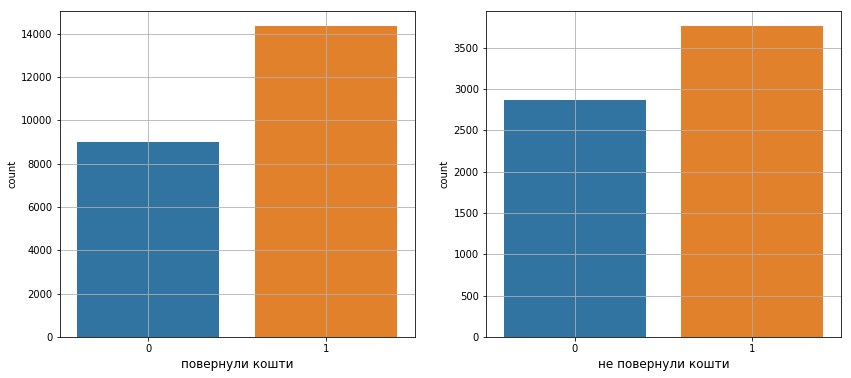

In [70]:
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.countplot(credit[credit.default == 0].SEX)
plt.grid(True)
plt.xlabel('повернули кошти', fontsize=12)
plt.subplot(122)
sns.countplot(credit[credit.default == 1].SEX)
plt.grid(True)
plt.xlabel('не повернули кошти', fontsize=12)
plt.show()

Знайдемо довірчий інтервал для долі:

In [79]:
conf_interval_return = proportion_confint(sum(credit[credit.default == 0].SEX), 
                                            credit.shape[0])
conf_interval_not_return = proportion_confint(sum(credit[credit.default == 1].SEX), 
                                            credit.shape[0])

In [80]:
print ('95%% confidence interval for a sex, return loan: [%f, %f]' % conf_interval_return)
print ('95%% confidence interval for a sex, not return loan [%f, %f]' % conf_interval_not_return)

95% confidence interval for a sex, return loan: [0.472662, 0.483967]
95% confidence interval for a sex, not return loan [0.121698, 0.129194]


Здійснимо перевірку гіпотези Z-критерієм для долі двох незалежних вибірок, так як ознака стать підкорюється розподілу Бернуллі

| $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Довірчий інтервал}p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [81]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [84]:
print ("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(credit[credit.default == 0].SEX, credit[credit.default == 1].SEX))

95% confidence interval for a difference between proportions: [0.033671, 0.060584]


95% довірчий інтервал не включає у себе нуль, отже вибірки дійсно відрізняються. Жінок у групі повернувших кредит більше, ніж у групі не повернувших кредит

In [85]:
print ("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(credit[credit.default == 0].SEX,\
                                                                           credit[credit.default == 1].SEX)))

p-value: 0.000000


На рівні значимості 0,05 відхиляється нульова гіпотеза про рівність гендерного складу двох вибірок

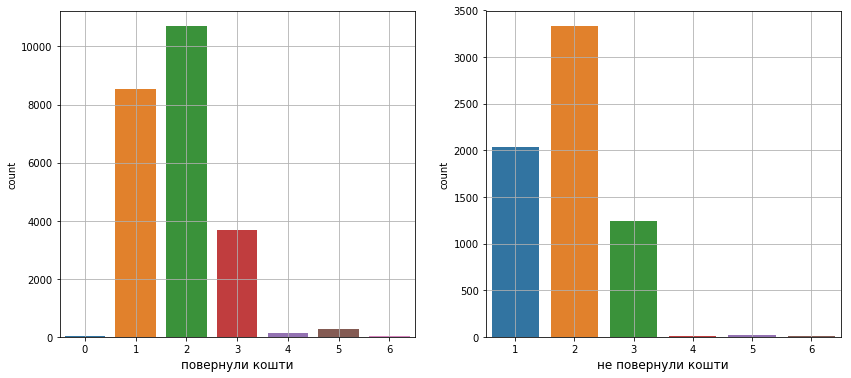

In [87]:
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.countplot(credit[credit.default == 0].EDUCATION)
plt.grid(True)
plt.xlabel('повернули кошти', fontsize=12)
plt.subplot(122)
sns.countplot(credit[credit.default == 1].EDUCATION)
plt.grid(True)
plt.xlabel('не повернули кошти', fontsize=12)
plt.show()

In [91]:
m_return = np.mean(credit[credit.default == 0].EDUCATION)
m_not_return = np.mean(credit[credit.default == 1].EDUCATION)

In [88]:
observed_frequences_return = np.bincount(credit[credit.default == 0].EDUCATION)
observed_frequences_not_return = np.bincount(credit[credit.default == 1].EDUCATION)

In [89]:
observed_frequences_return

array([   14,  8547, 10699,  3680,   116,   262,    43], dtype=int64)

In [90]:
observed_frequences_not_return

array([   0, 2036, 3330, 1237,    7,   18,    8], dtype=int64)

In [99]:
expected_frequences_return = [len(credit[credit.default == 0].EDUCATION)*stats.poisson.pmf(x, m_return) for x in \
                              range(min(credit[credit.default == 0].EDUCATION),max(credit[credit.default == 0].EDUCATION) + 1)]
expected_frequences_not_return = [len(credit[credit.default == 1].EDUCATION)*stats.poisson.pmf(x, m_not_return) for x in \
                              range(min(credit[credit.default == 0].EDUCATION),max(credit[credit.default == 0].EDUCATION) + 1)]

In [100]:
expected_frequences_return 

[3704.9346787811805,
 6822.275376787382,
 6281.276912017099,
 3855.4526621896825,
 1774.8598858076878,
 653.6462283959532,
 200.6042821148403]

In [101]:
expected_frequences_not_return

[997.846233896874,
 1890.5847948742307,
 1791.0128560845171,
 1131.1233996157641,
 535.775109379483,
 203.0229189339435,
 64.11008538669054]

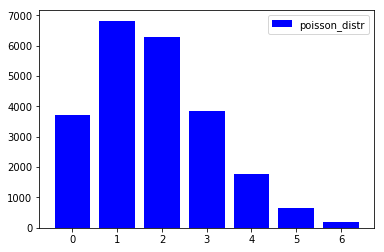

In [103]:
plt.bar(range(len(expected_frequences_return )), expected_frequences_return , color = 'b', label = 'poisson_distr')
plt.legend()

In [104]:
stats.chisquare(observed_frequences_return, expected_frequences_return, ddof = 1)

Power_divergenceResult(statistic=9136.977660480894, pvalue=0.0)